In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pytorch_lightning as pl
import torch
from src.dm import DFTemporalDataModule

In [3]:
dm = DFTemporalDataModule(batch_size=4)
dm.setup()

train: 8689
test: 2773


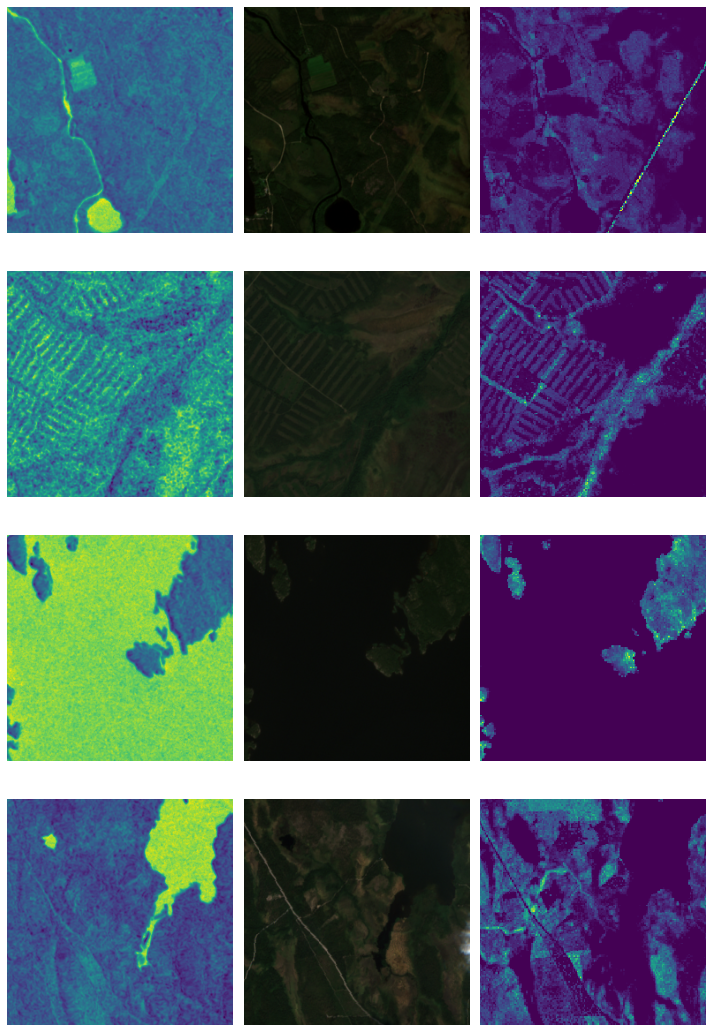

In [7]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(4, 3, figsize=(10, 15))
dl = dm.train_dataloader()
s1, s2, labels = next(iter(dl))
for i in range(4):
	ax[i, 0].imshow(s1[i][-1][0])
	ax[i, 0].axis('off')
	ax[i, 1].imshow(s2[i][-1][:3,...].permute(1, 2, 0))
	ax[i, 1].axis('off')
	ax[i, 2].imshow(labels[i])
	ax[i, 2].axis('off')
plt.tight_layout()
plt.show()

In [8]:
import pytorch_lightning as pl
from src.module import UnetTemporalDF

dm = DFTemporalDataModule(batch_size=4, months=['April'])

hparams = {
	'encoder': 'resnet18',
	'pretrained': 'imagenet',
	'seq_len': 1,
	'in_channels_s1': 2,
	'in_channels_s2': 3,
	'optimizer': 'Adam',
	'optimizer_params': {
		'lr': 1e-3
	},
}

module = UnetTemporalDF(hparams)

trainer = pl.Trainer(
	gpus=1,
	precision=16,
	overfit_batches=1,
	max_epochs=300,
	logger=None,
	enable_checkpointing=False,
)

trainer.fit(module, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.


train: 8689
test: 2773


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name              | Type             | Params
-------------------------------------------------------
0 | encoder1          | ResNetEncoder    | 11.2 M
1 | encoder2          | ResNetEncoder    | 11.2 M
2 | decoder           | UnetDecoder      | 5.1 M 
3 | segmentation_head | SegmentationHead | 145   
-------------------------------------------------------
27.5 M    Trainable params
0         Non-trainable params
27.5 M    Total params
54.948    Total estimated model params size (MB)
/home/juan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:471: UserWarning: You requested to overfit but enabled training dataloader shuffling. We are turning off the training dataloader shuffling for you.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers 

Training: 0it [00:00, ?it/s]

In [ ]:
import torch 

dl = dm.train_dataloader(shuffle=False)
s1s, s2s, labels = next(iter(dl))
preds = module.predict(s1s, s2s)


fig, ax = plt.subplots(4, 3, figsize=(10, 16))
for i in range(4):
	ax[i, 0].imshow(s2s[i][-1].permute(1, 2, 0))
	ax[i, 0].axis('off')
	ax[i, 1].imshow(labels[i])
	ax[i, 1].axis('off')
	ax[i, 2].imshow(preds[i])
	ax[i, 2].axis('off')
	ax[i, 2].set_title(torch.sqrt(
            torch.sum((preds[i]*12905.3 - labels[i]*12905.3)**2)).item())
plt.tight_layout()
plt.show()